In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.pandas.set_option('display.max_columns',None)

In [2]:
data = pd.read_excel('Flight_Train.xlsx')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
data.dropna(inplace=True)

# EDA
First, we have to convert the features containing information of date and time into seperate date-month or hour-minute features.

In [5]:
#Since all the data is of the same year(2019), we are going to consider only the journey date and month
doj = list(data['Date_of_Journey'])
journey_date = []
journey_month = []
for i in range(len(doj)):
    temp = doj[i].split('/')
    journey_date.append(int(temp[0]))
    journey_month.append(int(temp[1]))
 
data['journey_date'] = journey_date
data['journey_month'] = journey_month
data.drop('Date_of_Journey',axis=1,inplace=True)

In [6]:
data['dep_hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['dep_min'] = pd.to_datetime(data['Dep_Time']).dt.minute

In [7]:
data['arrival_hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour
data['arrival_min'] = pd.to_datetime(data['Arrival_Time']).dt.minute

In [8]:
data.drop(['Dep_Time','Arrival_Time'],axis=1,inplace=True)

In [9]:
#checking %age of no info in additional info column
data['info'] = np.where(data['Additional_Info']=='No info',1,0)
print('missing values:',data['info'].mean()*100,'%')

missing values: 78.1127129750983 %


In [10]:
data['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [11]:
data.drop(['Additional_Info','info','Route'],axis=1,inplace=True)

In [12]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,journey_date,journey_month,dep_hour,dep_min,arrival_hour,arrival_min
0,IndiGo,Banglore,New Delhi,2h 50m,non-stop,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,7h 25m,2 stops,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,19h,2 stops,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,5h 25m,1 stop,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,4h 45m,1 stop,13302,1,3,16,50,21,35


In [13]:
#Converting total duration into minutes only
duration = list(data['Duration'])
duration_in_min = []
for i in range(len(duration)):
    time = 0
    d = duration[i].split()
    if len(d) == 2:
        time += int(d[0][:-1])*60
        time += int(d[1][:-1])
    else:
        if 'h' in d[0]:
            time += int(d[0][:-1])*60
        else:
            time += int(d[0][:-1])
    duration_in_min.append(time)

In [14]:
data['Duration_min'] = duration_in_min
data.drop('Duration',axis=1,inplace=True)
data.head()

,Airline,Source,Destination,Total_Stops,Price,journey_date,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_min
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,170
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,285


## Handling Categorical Features
Here, we will try to find out the nature of different categorical variables and impact of their values on the target and will perform encoding accordingly.

In [15]:
categorical_feat = [feat for feat in data.columns if data[feat].dtype=='O' and feat != 'Date_of_Journey']

In [16]:
for feat in categorical_feat:
    print(feat,': cardinality = ',len(data[feat].unique()))

Airline : cardinality =  12
Source : cardinality =  5
Destination : cardinality =  6
Total_Stops : cardinality =  5


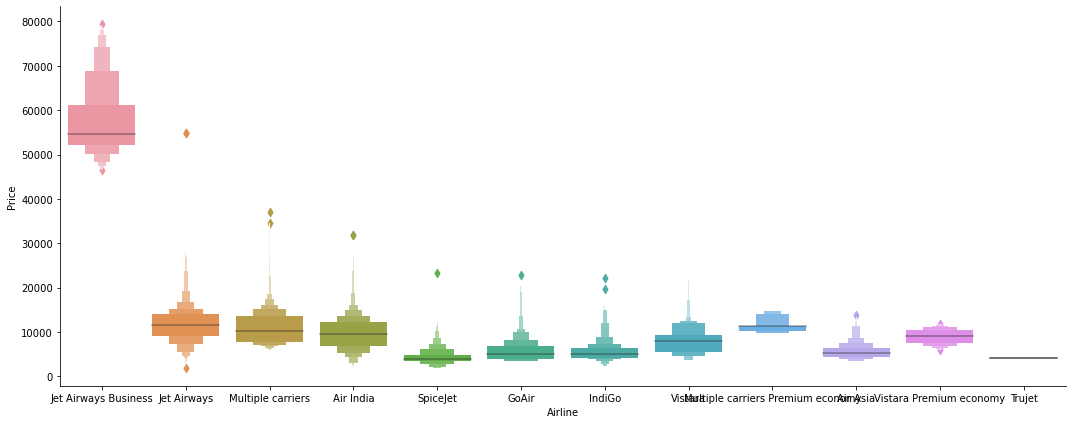

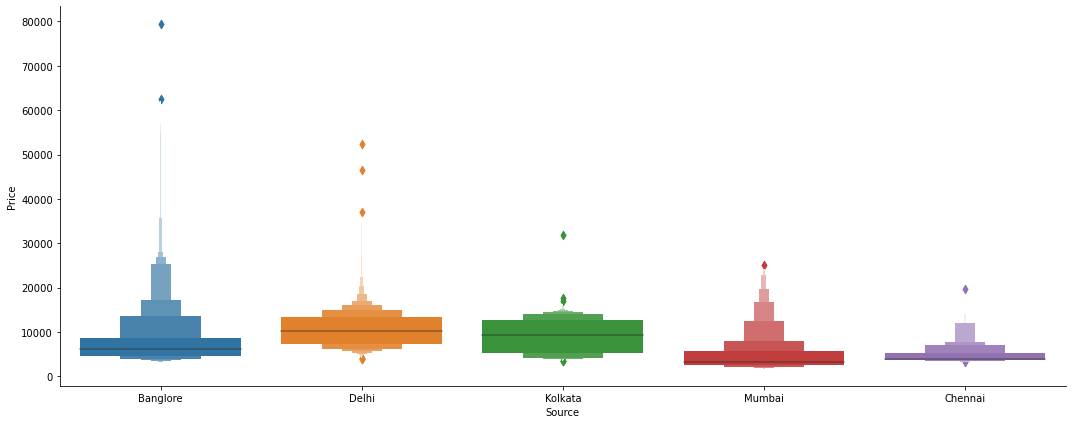

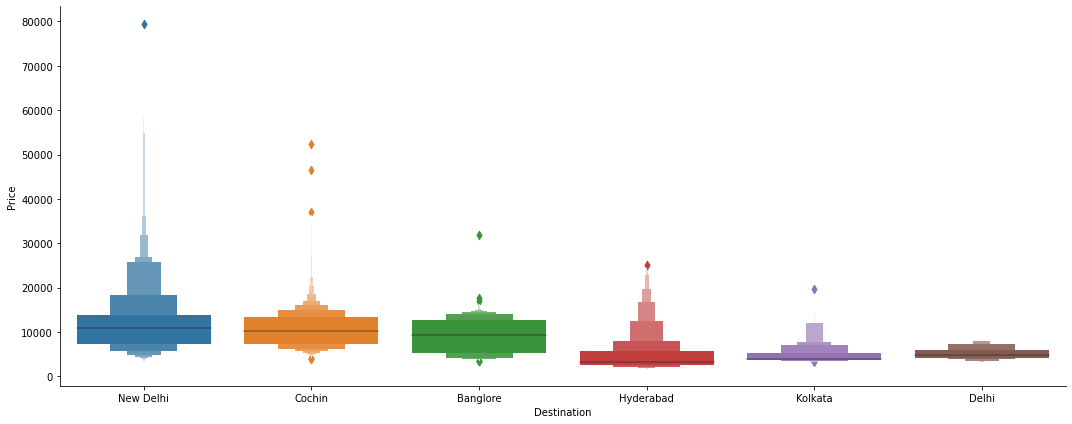

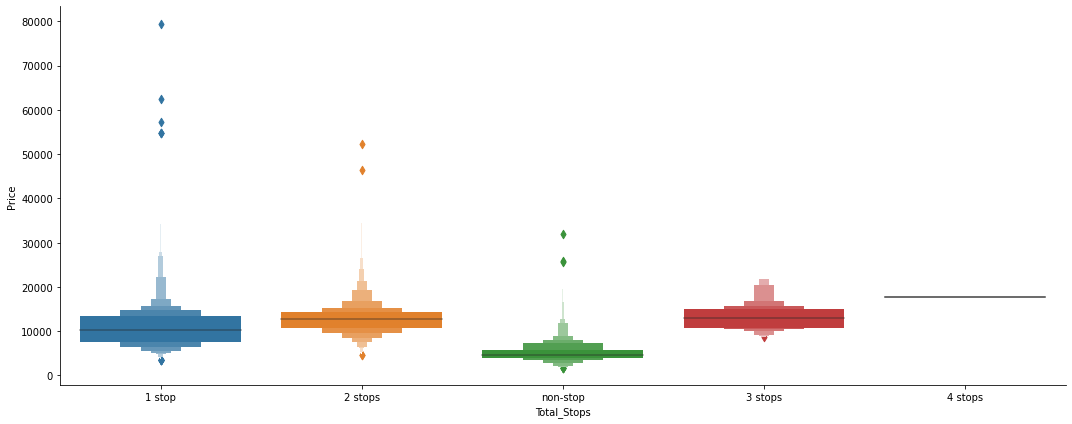

In [17]:
for feat in categorical_feat:
    sns.catplot(y='Price',x=feat,data=data.sort_values('Price',ascending=False),kind='boxen',height=6,aspect=2.5)
    plt.show()

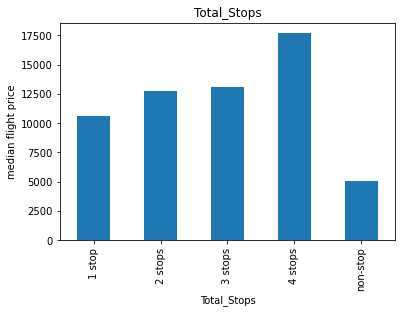

In [18]:
data.groupby('Total_Stops')['Price'].mean().plot.bar()
plt.xlabel('Total_Stops')
plt.ylabel('median flight price')
plt.title('Total_Stops')
plt.show()   

In [19]:
#Performing Label Encoding in Total_Stops feature because the price seems to be affected by number of stops. 
#Means, as the number of stops increase the price is also increasing.

data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)

data['Total_Stops'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [20]:
#Performing One Hot Encoding on all other categorical features
ohe_feat = ['Airline','Source','Destination']
data1 = pd.get_dummies(data[ohe_feat],drop_first=True)
data1.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
data = pd.concat([data,data1],axis=1)
data.head()

,Airline,Source,Destination,Total_Stops,Price,journey_date,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,170,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,445,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,1140,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,325,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,285,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
data.drop(ohe_feat,axis=1,inplace=True)
data.head()

,Total_Stops,Price,journey_date,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Duration_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,170,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,445,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,1140,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,325,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,285,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
data.shape

(10682, 29)

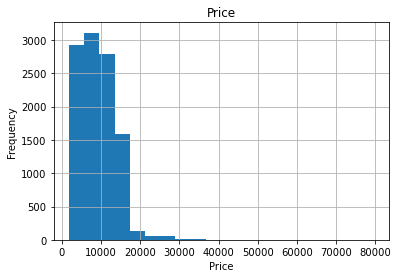

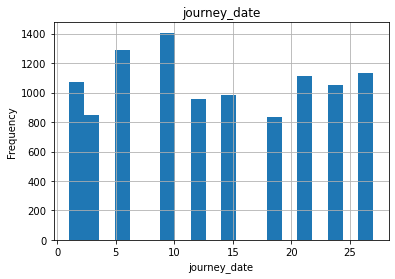

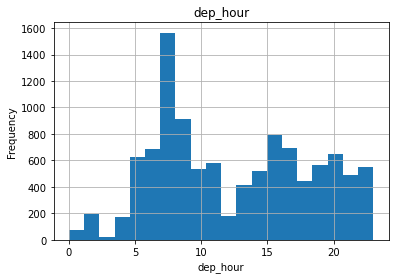

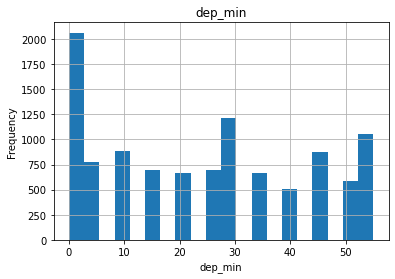

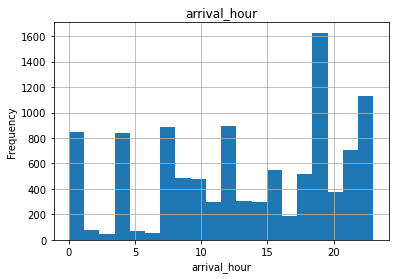

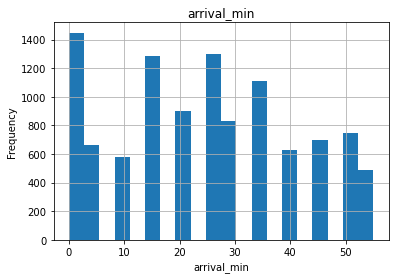

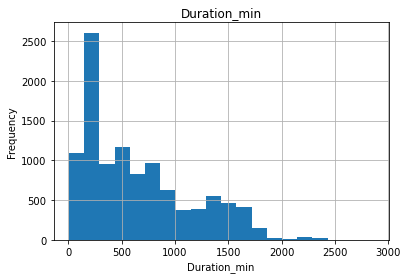

In [24]:
#Checking the gaussian(normal) distribution of some continuous features.
feat_dist = ['Price','journey_date','dep_hour','dep_min','arrival_hour','arrival_min','Duration_min']
for feat in feat_dist:
    data[feat].hist(bins=20)
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.title(feat)
    plt.show()

# Outliers detection and Handling

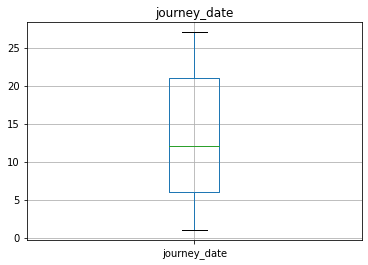

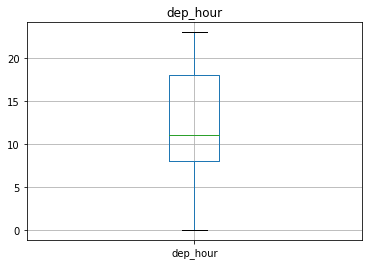

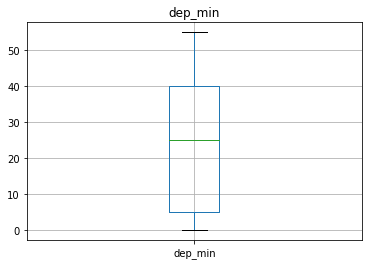

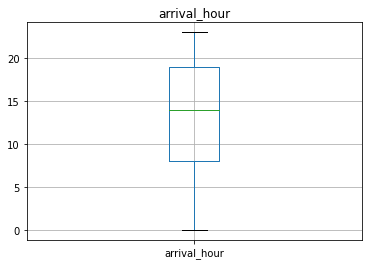

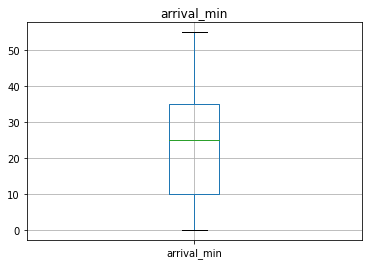

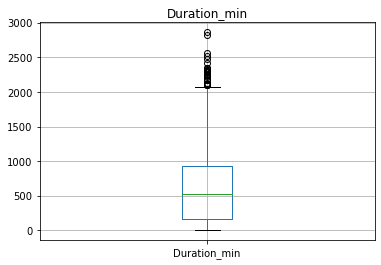

In [25]:
for feat in feat_dist[1:]:
    data.boxplot(column=feat)
    plt.title(feat)
    plt.show()    

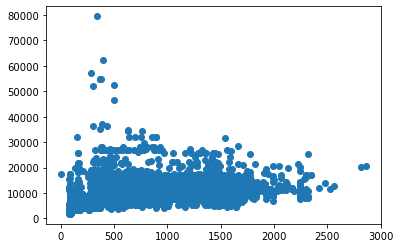

In [26]:
plt.scatter(x=data['Duration_min'],y=data['Price'])
plt.show()

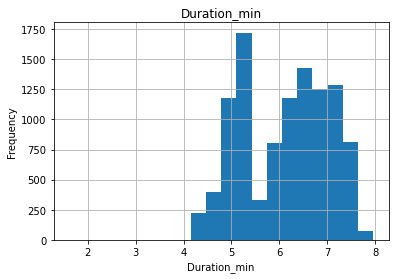

In [27]:
#Converting Duration_min feature into log normal distribution
np.log(data['Duration_min']).hist(bins=20)
plt.xlabel(feat)
plt.ylabel('Frequency')
plt.title(feat)
plt.show()

In [28]:
#Detecting the number of outliers using z-score method
count = 0
mean = data['Duration_min'].mean()
std = data['Duration_min'].std()
threshold = 3
for x in data['Duration_min']:
    z_score = (x-mean)/std
    if abs(z_score) > threshold:
        count += 1
print('Duration_min',': No of outliers =',count)

Duration_min : No of outliers = 66


In [29]:
#Detecting the number of outliers using z-score method after log conversion
count = 0
log_duration = np.log(data['Duration_min'])
mean = log_duration.mean()
std = log_duration.std()
threshold = 3
values = []
for x in log_duration:
    z_score = (x-mean)/std
    if abs(z_score) > threshold:
        count += 1
        values.append(x)
print('log_Duration_min',': No of outliers =',count,values)

log_Duration_min : No of outliers = 1 [1.6094379124341003]


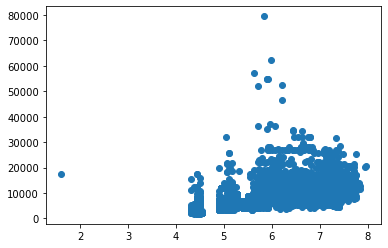

In [30]:
plt.scatter(x=log_duration,y=data['Price'])
plt.show()

In [31]:
data['log_duration'] = np.round_(np.log(data['Duration_min']),decimals=3)
data.drop('Duration_min',axis=1,inplace=True)
data.head()

,Total_Stops,Price,journey_date,journey_month,dep_hour,dep_min,arrival_hour,arrival_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,log_duration
0,0,3897,24,3,22,20,1,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.136
1,2,7662,1,5,5,50,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.098
2,2,13882,9,6,9,25,4,25,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,7.039
3,1,6218,12,5,18,5,23,30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5.784
4,1,13302,1,3,16,50,21,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.652


In [32]:
#dropping the record having outlier
i = data[(data.log_duration == values[0])].index
data.drop(i,inplace=True)
data.shape

(10682, 29)

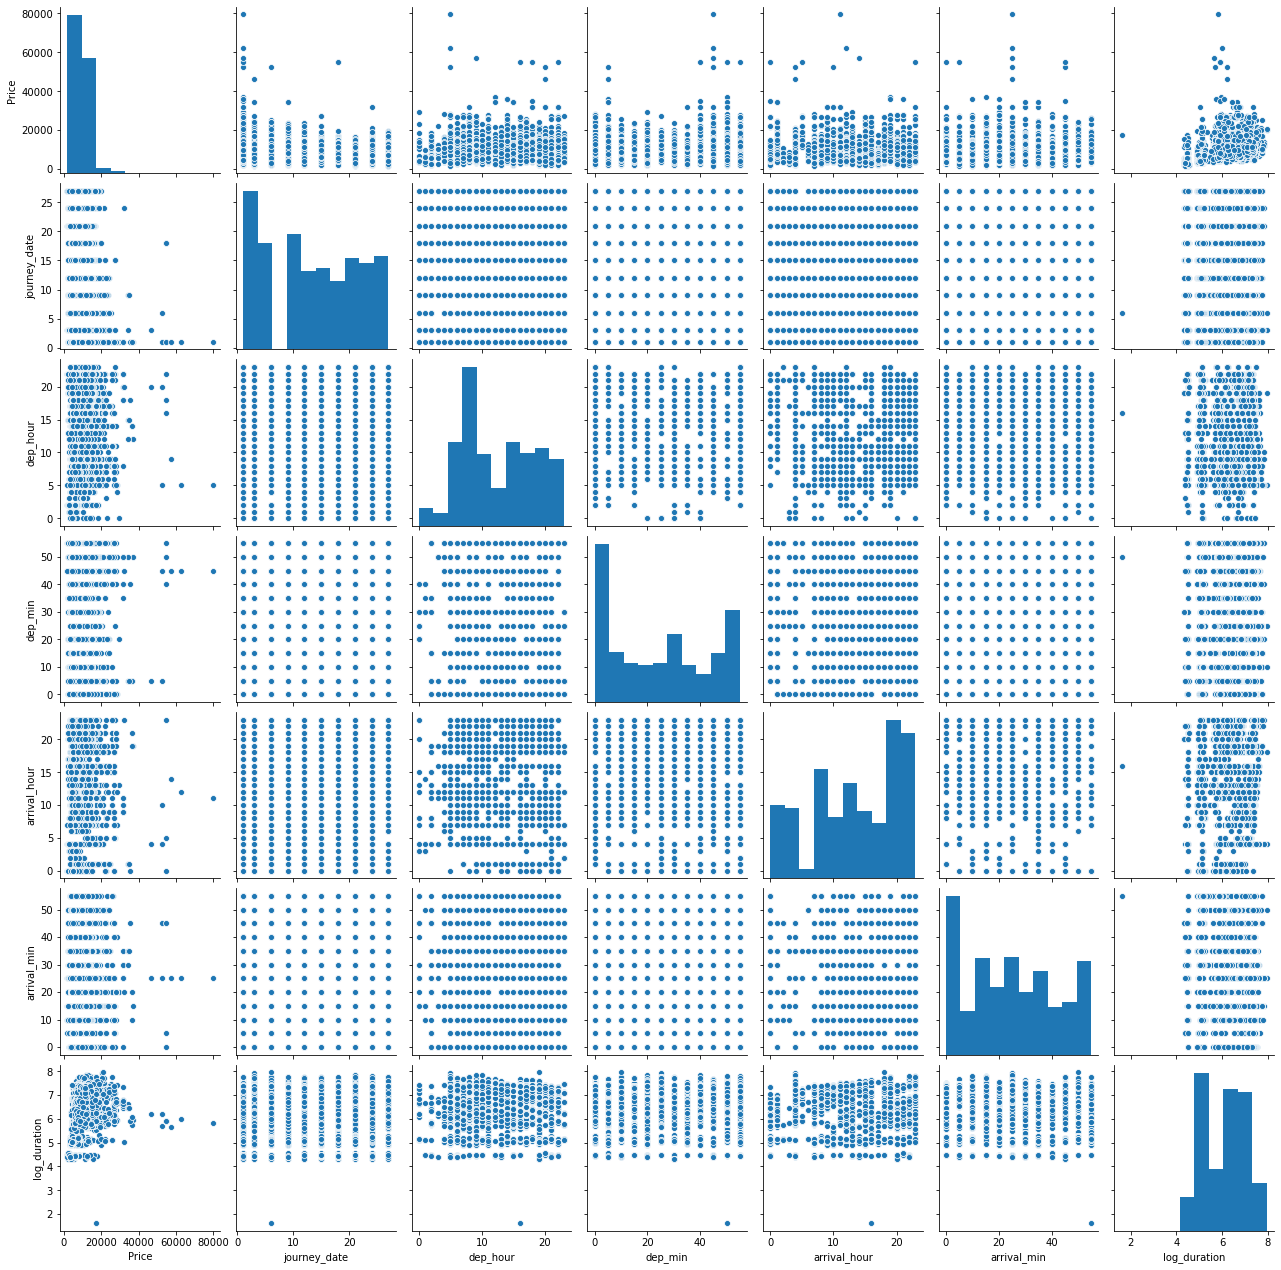

In [33]:
feat_dist.remove('Duration_min')
feat_dist.append('log_duration')
sns.pairplot(data[feat_dist])

In [34]:
data.to_csv('Flight_processed.csv',index=False)

# Feature Selection
We will use the following methods for feature selection in case of our dataset.
1. Pearson's Coorelation
2. SelectKBest
3. ExtraTreeRegressor

In [2]:
data = pd.read_csv('Flight_processed.csv')
y = data['Price']
X = data.drop('Price',axis=1)

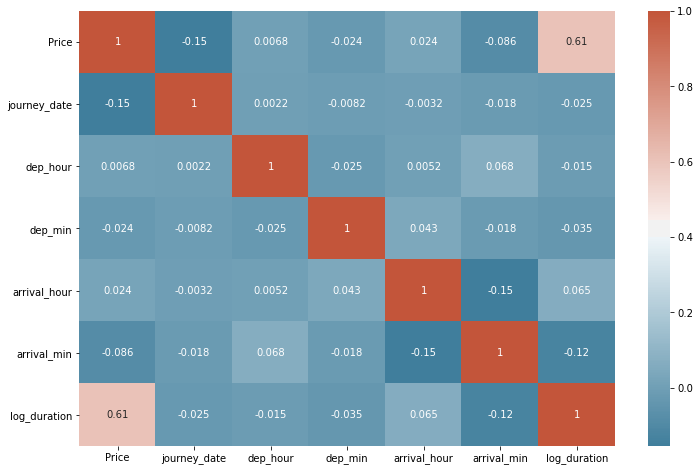

In [36]:
#Plotting Heatmap for coorelation coefficients
#This shows that no two features are highly coorelated.So, we can't drop any feature for now.
plt.figure(figsize=(12,8))
corr = data[feat_dist].corr()
sns.heatmap(corr,annot=True,cmap=sns.diverging_palette(230, 20, as_cmap=True))

In [37]:
y = data['Price']
X = data.drop(['Price'],axis=1)

In [38]:
#Checking Feature Importance using ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

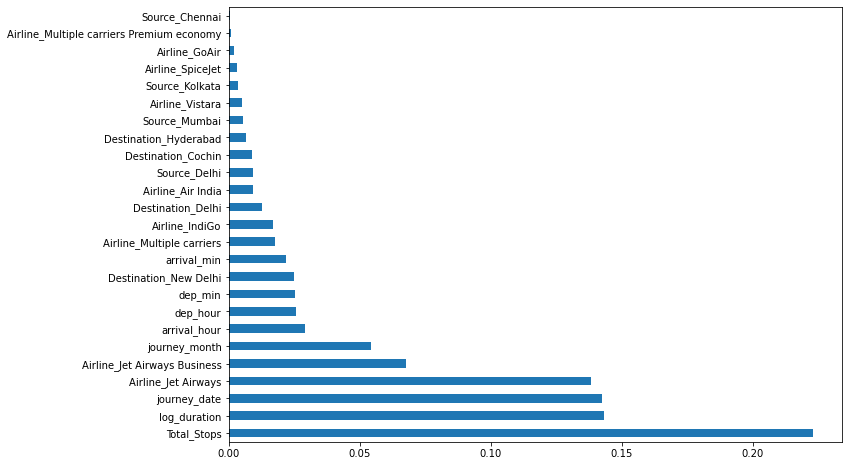

In [39]:
feat_importance = pd.Series(model.feature_importances_,index = X.columns)
plt.figure(figsize=(11,8))
feat_importance.nlargest(25).plot(kind='barh')
plt.show()

In [40]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [41]:
feat_select_model = SelectFromModel(Lasso(alpha=0.05,random_state=0))
feat_select_model.fit(X,y)

SelectFromModel(estimator=Lasso(alpha=0.05, random_state=0))

In [42]:
selected_feat = X.columns[(feat_select_model.get_support())]
print('Total features:',X.shape[1])
print('Selected features:',len(selected_feat))
#This shows that all the features present and important enough to predict our output. Thus, we won't drop any feature.

Total features: 28
Selected features: 28


# Model building & Evaluation

In [3]:
#Using Random Forest Regressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
rf.fit(X_train,y_train)

RandomForestRegressor()

In [5]:
y_pred = rf.predict(X_test)
print('mean square error:',mean_squared_error(y_test,y_pred))
print('mean absolute error:',mean_absolute_error(y_test,y_pred))
print('r2 score:',r2_score(y_test,y_pred))

mean square error: 3589125.308378814
mean absolute error: 1141.798206667277
r2 score: 0.8258807204970067


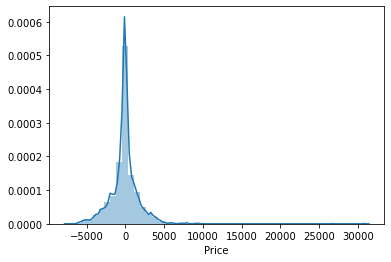

In [6]:
sns.distplot(y_test-y_pred)

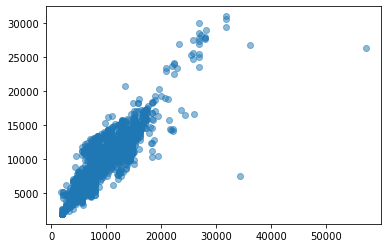

In [7]:
plt.scatter(y_test,y_pred,alpha=0.5)

In [8]:
#Hyperparameter tuning using RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(15,40,6)]
min_samples_split = [2,5,10,15,100]
min_samples_leaf = [1,2,5]

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [10]:
random_grid = {'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,
               'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

In [11]:
rf_model = RandomizedSearchCV(estimator = rf,param_distributions=random_grid,scoring='neg_mean_squared_error',
                          n_iter=10,cv=5,verbose=2,random_state=42,n_jobs=1)

In [12]:
rf_model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=  14.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=  18.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=  17.2s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=  16.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, total=  12.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=35 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=35, total=  12.9s
[CV] n_estimators=1000, min_samples_split=2

[CV]  n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40, total=  29.5s
[CV] n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40 
[CV]  n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40, total=  28.9s
[CV] n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40 
[CV]  n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40, total=  28.9s
[CV] n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40 
[CV]  n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40, total=  29.1s
[CV] n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40 
[CV]  n_estimators=900, min_samples_split=15, min_samples_leaf=5, max_features=auto, max_depth=40, total=  28.8s
[CV] n_estimators=200, min_samples_split=10

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [15, 20, 25, 30, 35, 40],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [13]:
rf_model.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40}

In [14]:
y_pred = rf_model.predict(X_test)

In [15]:
print('mean square error:',mean_squared_error(y_test,y_pred))
print('mean absolute error:',mean_absolute_error(y_test,y_pred))
print('r2 score:',r2_score(y_test,y_pred))

mean square error: 3743980.1536330385
mean absolute error: 1255.1459604752747
r2 score: 0.8183682455159109


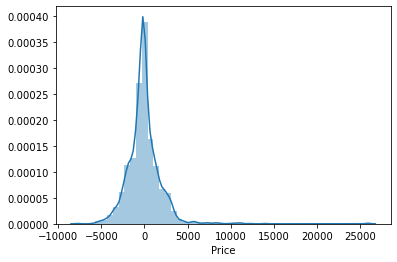

In [16]:
sns.distplot(y_test-y_pred)

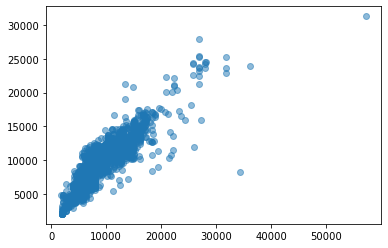

In [17]:
plt.scatter(y_test,y_pred,alpha=0.5)

In [18]:
import pickle

In [19]:
file = open('rfmodel_flight.pkl','wb')
pickle.dump(rf_model,file)

In [20]:
model = open('rfmodel_flight.pkl','rb')
rf1 = pickle.load(model)

In [21]:
#Checking the pickle file
pred = rf1.predict(X_test)
r2_score(y_test,pred)

0.8183682455159109